# Introduction

**Contents:**

1. Introduces the `EconModelClass`
1. Solves and simulates a simple consumption-saving model

**Solution methods:** Value function iteration (`vfi`) and the endogenous grid-point method (`egm`)

**Simulation methods:** Monte Carlo (`mc`) and the historgram method (`hist`)

# Setup

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import numba as nb

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

from EconModel import EconModelClass, jit  

# EconModel

**Docunmentation:** [EconModel](https://github.com/NumEconCopenhagen/EconModel) github repository

**Examples:** [EconModelNotebooks](https://github.com/NumEconCopenhagen/EconModelNotebooks) github repository

**Overview:** `EconModel` is a small package for easily working with economic models in Python. It has four objectives:

1. Make it easy to write well-structed code.
1. Provide standard functionality for copying, saving and loading.
1. Provide an easy interface to call [numba](http://numba.pydata.org/) JIT compilled functions.
1. Provide an easy interface to call C++ functions [*not relevant in this course*].

The two first objectives should be of interest to everybody, while the two last objectives are for more advanced users.

## Baseline Usage

The model is **required** to have the following three methods:

1. `.settings()`: Choose fundamental settings.
1. `.setup()`: Set free parameters.
1. `.allocate()`: Set compound parameters and allocate arrays.

When the model is initialized `.settings()`, `.setup()` and `.allocate()` are all called (in that order).

Per default the namespaces `.par` (for parameters), `.sol` (for solution objects) and `.sim` (for simulation objects) are available. The philosophy of the package is that all the content of the model is contained in these namespaces. After the model has been initialized, no additional entries should be added to the namespaces, and each entry should only change *value(s)* (or shape for arrays), but never *type* (or number of dimensions for arrays).

In [2]:
class MyModelClass(EconModelClass):
    
    # __init__ is inherited from EconModelClass
    
    def settings(self): # required
        """ choose settings """
            
        pass # nothing chosen here
    
    def setup(self): # required
        """ set free parameters """
        
        par = self.par
        
        par.N = 10
        par.a = 2.0
        par.b = 1.0
        par.threads = 4
        par.txt = 'a'
        par.txtlist = 'N|threads'
        
    def allocate(self): # required
        """ set compound parameters and allocate arrays """
        
        par = self.par
        sol = self.sol
        
        par.X = np.linspace(0,10,par.N)
        sol.Y = np.zeros(par.N)
    
    def solve(self): # user-defined
        """ solve the model"""
        
        par = self.par
        sol = self.sol
        
        sol.Y[:] = par.X*(par.a+par.b)


In `.settings()` the user can change the default behavior by specifying: 

1. `self.savefolder = str`: Filepath to save in and load from (default: 'saved').
1. `self.namespaces = [str]`: List of namespaces (in addition to `.par`, `.sol`, `.sol`).
1. `self.other_attrs = [str]`: List of additional attributes to be copied and saved.


### Setup

In [3]:
model = MyModelClass(name='example')

In [4]:
model.solve()

**Print description:**

In [5]:
print(model)

Modelclass: MyModelClass
Name: example

namespaces: ['par', 'sol', 'sim']
other_attrs: []
savefolder: saved
cpp_filename: None

par:
 N = 10 [int]
 a = 2.0 [float]
 b = 1.0 [float]
 threads = 4 [int]
 txt = a [str]
 txtlist = N|threads [str]
 X = ndarray with shape = (10,) [dtype: float64]
 memory, gb: 0.0

sol:
 Y = ndarray with shape = (10,) [dtype: float64]
 memory, gb: 0.0

sim:
 memory, gb: 0.0



**Updating at initialization:**

In [6]:
model_alt = MyModelClass(name='alt',par={'a':3.0,'b':1.2})
print(model_alt.par.a)

3.0


**Unpack for later use:**

In [7]:
par = model.par
sol = model.sol

**Under the hood:** Each namespace is techically a `SimpleNamespace` (from `types`)

In [8]:
type(par)

types.SimpleNamespace

### Copy, save and load

In [9]:
model_copy = model.copy(name='example_copy')
model_copy.save()

In [10]:
model_loaded = MyModelClass(name='example_copy',load=True)
print(model_loaded)

Modelclass: MyModelClass
Name: example_copy

namespaces: ['par', 'sol', 'sim']
other_attrs: []
savefolder: saved
cpp_filename: None

par:
 N = 10 [int]
 a = 2.0 [float]
 b = 1.0 [float]
 threads = 4 [int]
 txt = a [str]
 txtlist = N|threads [str]
 X = ndarray with shape = (10,) [dtype: float64]
 memory, gb: 0.0

sol:
 Y = ndarray with shape = (10,) [dtype: float64]
 memory, gb: 0.0

sim:
 memory, gb: 0.0



### To and from dictionary 

In [11]:
modeldict = model.as_dict()
model_dict = MyModelClass(name='example_dict',from_dict=modeldict)
print(model_dict)

Modelclass: MyModelClass
Name: example_dict

namespaces: ['par', 'sol', 'sim']
other_attrs: []
savefolder: saved
cpp_filename: None

par:
 N = 10 [int]
 a = 2.0 [float]
 b = 1.0 [float]
 threads = 4 [int]
 txt = a [str]
 txtlist = N|threads [str]
 X = ndarray with shape = (10,) [dtype: float64]
 memory, gb: 0.0

sol:
 Y = ndarray with shape = (10,) [dtype: float64]
 memory, gb: 0.0

sim:
 memory, gb: 0.0



## Numba

**Goal:** Call [numba](http://numba.pydata.org/) JIT compilled functions easily using namespaces.

**Problem:** [numba](http://numba.pydata.org/) only allows specific types (and not e.g. `SimpleNamespace`).

**Under-the-hood:** `jit(model)` temporarily turns all namespaces into `namedtuples`, which can be used as input in JIT compilled functions. 

In [12]:
@nb.njit
def fun(par,sol):
    sol.Y[:] = par.X*(par.a+par.b)

In [13]:
def test_numba(model):
    with jit(model) as model_jit:
        fun(model_jit.par,model_jit.sol)

In [14]:
%time test_numba(model)
%time test_numba(model)

Wall time: 1.29 s
Wall time: 0 ns


**Note:** The first run is slower due to compiling.

**Check result:**

In [15]:
assert np.allclose(par.X*(par.a+par.b),sol.Y)

### Advanced: Recompilling

When a new model is created, re-compilation of JIT functions are normally necessary:

In [16]:
model_new = MyModelClass(name='numba_new')
%time test_numba(model_new)
%time test_numba(model_new)

Wall time: 294 ms
Wall time: 997 µs


This is *not* the case, when a copy is made instead:

In [17]:
model_new_ = model_new.copy(name='numba_new_copy')
%time test_numba(model_new_)

Wall time: 2 ms


### Advanced: Type inference

When the model is created **all types are infered** and the information is saved in the nested-dict `_ns_specs`. E.g.:

In [18]:
model._ns_specs['types']

{'par': {'N': [int, numpy.int32],
  'a': [float, numpy.float64],
  'b': [float, numpy.float64],
  'threads': [int, numpy.int32],
  'txt': [str],
  'txtlist': [str],
  'X': [numpy.ndarray]},
 'sol': {'Y': [numpy.ndarray]},
 'sim': {}}

In [19]:
model._ns_specs['np_dtypes']

{'par': {'X': dtype('float64')}, 'sol': {'Y': dtype('float64')}, 'sim': {}}

In [20]:
model._ns_specs['np_ndims']

{'par': {'X': 1}, 'sol': {'Y': 1}, 'sim': {}}

**The types must NOT change afterwards**. If they do, an error is raised when using  `jit`.

In [21]:
def test_numba_errors(model):
    try:
        test_numba(model)
    except ValueError as e:
        print(f'ValueError: {e}')
    else:
        print('no errors raised')

In [22]:
model_test = model.copy()
model_test.par.a = 1
test_numba_errors(model_test)

ValueError: par.a has type <class 'int'>, should be in [<class 'float'>, <class 'numpy.float64'>]


In [23]:
model_test = model.copy()
model_test.par.c = np.nan
test_numba_errors(model_test)

ValueError: c is not allowed in .par


In [24]:
model_test = model.copy()
model_test.par.X = np.zeros((1,1))
test_numba_errors(model_test)

ValueError: par.X has ndim 2, should be 1


In [25]:
model_test = model.copy()
model_test.par.X = model.par.X.astype('int')
test_numba_errors(model_test)

ValueError: par.X has dtype int32, should be float64


**If types *must* to be changed, then it is necessary to re-infer types:**

In [26]:
model_test = model.copy()
model_test.par.a = 1
model_test.infer_types()
test_numba_errors(model_test)

no errors raised


**Namedtuples** are immutables, so attributes cannot be changed while using `jit`:

In [27]:
try:
    with jit(model,show_exc=True) as model_jit:
        model_jit.par.a = 3.0
except AttributeError as e:
    pass

Traceback (most recent call last):
  File "C:\Users\gmf123\AppData\Local\Temp\ipykernel_26580\2942967087.py", line 3, in <cell line: 1>
    model_jit.par.a = 3.0
AttributeError: can't set attribute


## In-class exercise

1. Look at the notebook above and talk about it with the person next to you for 3 minutes
2. Write at least one question on https://padlet.com/jeppe_druedahl/advmacrohet

# Consumption-Saving Model

**Additional packages to consider:**

1. [quantecon](https://quantecon.org/)
2. [consav](https://github.com/NumEconCopenhagen/ConsumptionSaving) ([notebooks](https://github.com/NumEconCopenhagen/ConsumptionSavingNotebooks))

**Local model file:**

In [28]:
from ConSavModel import ConSavModelClass

## Solve - value function interation (vfi)

In [29]:
model_vfi = ConSavModelClass()

In [30]:
par = model_vfi.par
sol = model_vfi.sol
sim = model_vfi.sim

In [31]:
model_vfi.solve(do_print=True,algo='vfi')

iteration    0 solved in 30.8 secs [max abs. diff. in c 5.03e+01]
iteration    1 solved in 0.1 secs [max abs. diff. in c 1.68e+01]
iteration    2 solved in 0.1 secs [max abs. diff. in c 8.29e+00]
iteration    3 solved in 0.1 secs [max abs. diff. in c 5.12e+00]
iteration    4 solved in 0.1 secs [max abs. diff. in c 3.24e+00]
iteration    5 solved in 0.1 secs [max abs. diff. in c 2.47e+00]
iteration    6 solved in 0.1 secs [max abs. diff. in c 1.75e+00]
iteration    7 solved in 0.1 secs [max abs. diff. in c 1.45e+00]
iteration    8 solved in 0.1 secs [max abs. diff. in c 1.13e+00]
iteration    9 solved in 0.1 secs [max abs. diff. in c 8.97e-01]
iteration  100 solved in 0.1 secs [max abs. diff. in c 3.58e-03]
iteration  200 solved in 0.1 secs [max abs. diff. in c 1.12e-04]
iteration  209 solved in 0.1 secs [max abs. diff. in c 0.00e+00]
model solved in 46.4 secs


**Question:** What role does `c_plus` play in `solve_hh_backwards_vfi`?

## Plot change in savings function

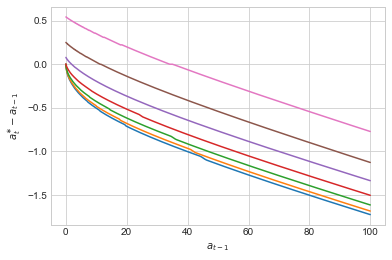

In [32]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
for i_z in range(par.Nz):
    ax.plot(par.a_grid,sol.a[i_z,:]-par.a_grid)
    
ax.set_xlabel('$a_{t-1}$')
ax.set_ylabel('$a_t^{\\ast}-a_{t-1}$');

**Note:** Good this ends up negative, then we do not extrapolate beyond the grid.

## Simulate - monte carlo 

In [33]:
model_mc = model_vfi.copy()

In [34]:
model_mc.prepare_simulate(algo='mc')
model_mc.simulate(algo='mc')

model prepared for simulation in 0.7 secs
model simulated in 2.2 secs


## Simulate - historgram

In [35]:
model_hist = model_vfi.copy()

In [36]:
model_hist.prepare_simulate(algo='hist')
model_hist.simulate(algo='hist')

model prepared for simulation in 0.0 secs
model simulated in 2.7 secs


## Compare simulation methods

**Aggregate savings in last 100 periods:**

In [37]:
A_mc = np.mean(model_mc.sim.a[-100:])
A_hist = np.sum(model_hist.sol.a*model_hist.sim.D[-100:])/100

print(f'{A_mc   = :7.4f}')
print(f'{A_hist = :7.4f}')

A_mc   =  1.2365
A_hist =  1.2352


**CDF:**

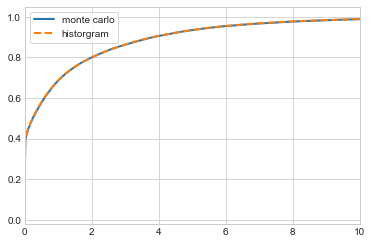

In [38]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

CDF_mc = np.zeros(par.Na)
for i_a in range(par.Na):
    CDF_mc[i_a] = np.sum(model_mc.sim.a[-1,:] < par.a_grid[i_a])/par.simN

CDF_hist = np.cumsum(np.sum(model_hist.sim.D[-1],axis=(0,)))

ax.plot(par.a_grid,CDF_mc,lw=2,label='monte carlo')
ax.plot(par.a_grid,CDF_hist,ls='--',lw=2,label='historgram')

ax.set_xlim([0.0,10.0])
ax.legend(frameon=True);

**Question 1:** How many liquidity constraints are there in the model?

**Question 2:** Look at the figure below. Does `simT` and `simN` matter for the distribution?

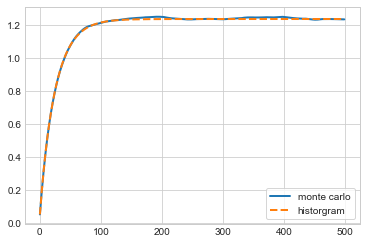

In [39]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

A_mc = np.mean(model_mc.sim.a,axis=1)
A_hist = np.sum(model_hist.sim.D*model_hist.sol.a,axis=(1,2))

ax.plot(A_mc,lw=2,label='monte carlo')
ax.plot(A_hist,ls='--',lw=2,label='historgram')

ax.legend(frameon=True);

## In-class exercise

1. Look at the code and talk about it with the person next to you for 5 minutes
2. Write at least one question on https://padlet.com/jeppe_druedahl/advmacrohet

## Solve - endogenous grid method (egm)

In [40]:
model_egm = model_vfi.copy()

In [41]:
model_egm.solve(do_print=True,algo='egm')

iteration    0 solved in 1.8 secs [max abs. diff. in c 5.02e+01]
iteration    1 solved in 0.0 secs [max abs. diff. in c 1.68e+01]
iteration    2 solved in 0.0 secs [max abs. diff. in c 8.39e+00]
iteration    3 solved in 0.0 secs [max abs. diff. in c 5.04e+00]
iteration    4 solved in 0.0 secs [max abs. diff. in c 3.36e+00]
iteration    5 solved in 0.0 secs [max abs. diff. in c 2.40e+00]
iteration    6 solved in 0.0 secs [max abs. diff. in c 1.80e+00]
iteration    7 solved in 0.0 secs [max abs. diff. in c 1.40e+00]
iteration    8 solved in 0.0 secs [max abs. diff. in c 1.12e+00]
iteration    9 solved in 0.0 secs [max abs. diff. in c 9.20e-01]
iteration  100 solved in 0.0 secs [max abs. diff. in c 3.44e-03]
iteration  200 solved in 0.0 secs [max abs. diff. in c 3.38e-06]
iteration  271 solved in 0.0 secs [max abs. diff. in c 9.54e-09]
model solved in 1.9 secs


**Question:** Why is `egm` so much faster than `vfi`?

## Compare solution methods

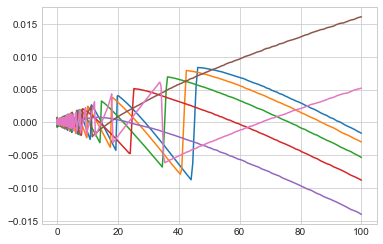

In [42]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
for i_z in range(par.Nz):
    ax.plot(par.a_grid,model_egm.sol.a[i_z,:]-model_vfi.sol.a[i_z,:])